In [1]:
# ! pip install -r requirements.txt

In [2]:
%reload_ext autoreload
%autoreload 2
%aimport

import foolbox as fb
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from src.utils import *

Modules to reload:
all-except-skipped

Modules to skip:



### Setup

In [3]:
# SETTINGS

SEED = 0
torch.manual_seed(SEED)  # doesn't seem to work on mac
USE_MANUAL_INDICES_PERMUTATION = True

DATASET_SIZE = 5  # 20

# EPSILONS = [0.0, 0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
EPSILONS = [0.0, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]

In [4]:
# Load pre-trained model for CIFAR10 dataset from: https://github.com/chenyaofo/pytorch-cifar-models 
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True, verbose=False)
model.eval()

# Load CIFAR10 test dataset
transform = transforms.Compose([
    transforms.ToTensor(),
])

full_test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
classes = full_test_dataset.classes
print("Classes:", classes)

# Get subset of test dataset
if USE_MANUAL_INDICES_PERMUTATION:
    indices = [6635, 4167, 1253, 7888, 636]  # 5 randomly preselected images
else:
    indices = torch.randperm(len(full_test_dataset)).tolist()[:DATASET_SIZE]
    
test_dataset = torch.utils.data.Subset(full_test_dataset, indices)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)
print("Subset indices:", indices)

Files already downloaded and verified
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Subset indices: [6635, 4167, 1253, 7888, 636]


### PGD & FGSM attacks with `foolbox`

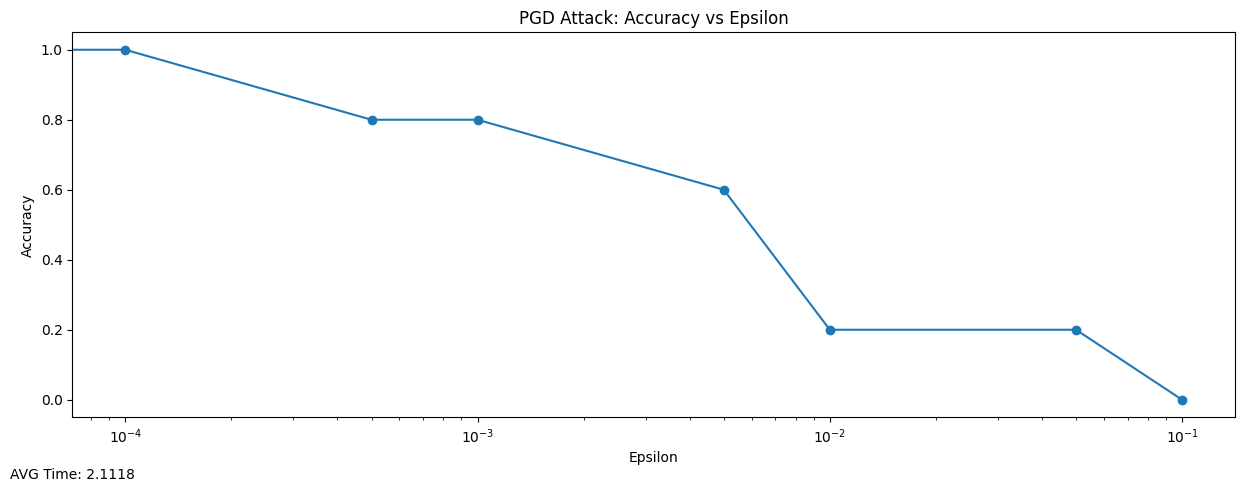

In [5]:
fb_model = fb.PyTorchModel(model, bounds=(0, 1))

# Projected Gradient Descent attack
pgd_attack = fb.attacks.LinfPGD()  # L_inf, for other norms use L2PGD or L1PGD
pgd_accuracies, pgd_time = attack_and_collect_stats(EPSILONS, fb_model, pgd_attack, test_loader, "PGD")

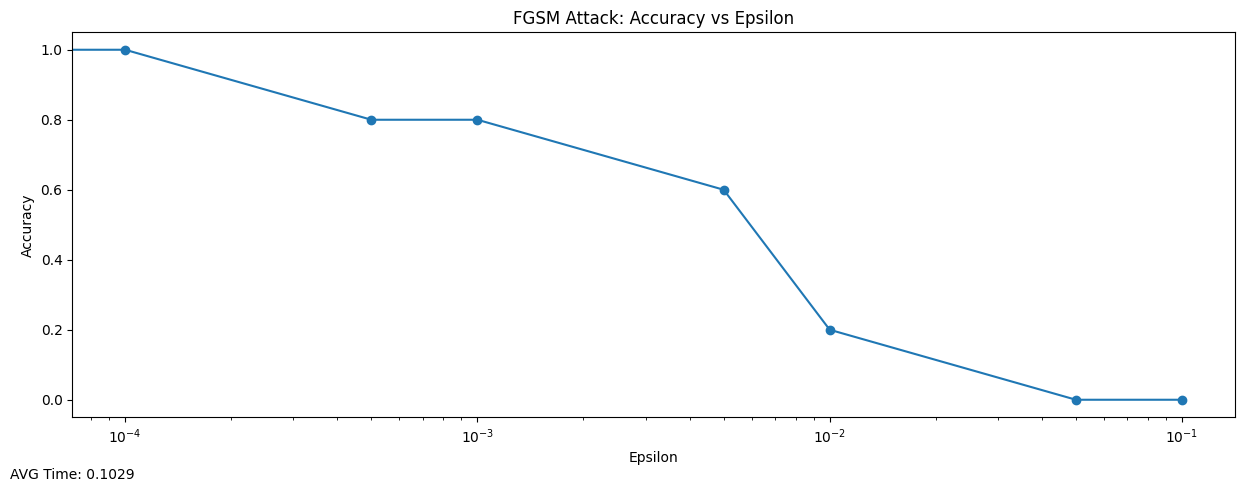

In [6]:
# Fast Gradient Sign Method attack
fgsm_attack = fb.attacks.LinfFastGradientAttack()  # L_inf, for other norms use L2FastGradientAttack or L1FastGradientAttack
fgsm_accuracies, fgsm_time = attack_and_collect_stats(EPSILONS, fb_model, fgsm_attack, test_loader, "FGSM")